In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

!pip install imblearn
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, LabelEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import  f1_score, accuracy_score, balanced_accuracy_score, roc_curve, auc, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import pickle


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
df = pd.read_csv("C:\\Deandra\PORTOFOLIO\Machine_failures\predictive_maintenance.csv")
pd.options.display.float_format = '{:.3f}'.format
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.100,308.600,1551,42.800,0,0,No Failure
1,2,L47181,L,298.200,308.700,1408,46.300,3,0,No Failure
2,3,L47182,L,298.100,308.500,1498,49.400,5,0,No Failure
3,4,L47183,L,298.200,308.600,1433,39.500,7,0,No Failure
4,5,L47184,L,298.200,308.700,1408,40.000,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.800,308.400,1604,29.500,14,0,No Failure
9996,9997,H39410,H,298.900,308.400,1632,31.800,17,0,No Failure
9997,9998,M24857,M,299.000,308.600,1645,33.400,22,0,No Failure
9998,9999,H39412,H,299.000,308.700,1408,48.500,25,0,No Failure


In [31]:
duplicate = df.duplicated().sum()
print('Total Duplicated values: ', duplicate)

Total Duplicated values:  0


In [32]:
missing_value = df.isna().sum().sum()
print('Total Missing Values: ', missing_value)

Total Missing Values:  0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [34]:
df.describe(include = ['int','float'])

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,300.005,310.006,1538.776,39.987,107.951,0.034
std,2886.896,2.000,1.484,179.284,9.969,63.654,0.181
min,1.000,295.300,305.700,1168.000,3.800,0.000,0.000
25%,2500.750,298.300,308.800,1423.000,33.200,53.000,0.000
50%,5000.500,300.100,310.100,1503.000,40.100,108.000,0.000
75%,7500.250,301.500,311.100,1612.000,46.800,162.000,0.000
max,10000.000,304.500,313.800,2886.000,76.600,253.000,1.000


In [35]:
df.Target.value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [36]:
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [37]:
rename_columns = {
    'UDI' : 'ID',
    'Air temperature [K]' : 'Air_temperature',
    'Process temperature [K]': 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Failure Type' : 'Failure_type'
}
df.rename(rename_columns, axis = 1, inplace = True)

In [38]:
count_failures = (df['Target'] == 1).sum()
print(f'Total Failures: {count_failures}')

sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print(f'sum total failures: {sum_failures}')

Total Failures: 339
sum total failures: 330


In [39]:
remove_rows = df[(df['Failure_type'] == 'No Failure') & (df['Target'] == 1)]
df.drop(remove_rows.index, inplace = True)

In [40]:
drop_columns = ['ID','Product ID','Target']
df.drop(drop_columns, axis = 1, inplace = True)

In [41]:
df = df.loc[df['Failure_type'] != 'Random Failures']

In [42]:
rename_type = {
    'L': 'Low',
    'M' : 'Medium',
    'H' : 'High'
}
df['Type'].replace(rename_type, inplace = True)

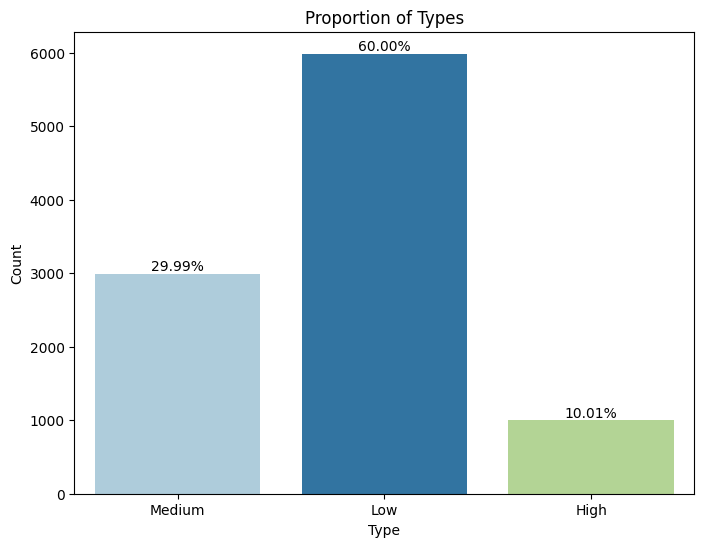

In [43]:
type_count = df['Type'].value_counts()

plt.figure(figsize =(8,6))
ax = sns.countplot(data = df, x = 'Type', palette = 'Paired')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

total = len(df)
for p in ax.patches:
  height = p.get_height()
  percentage = (height/total) * 100
  ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
              ha = 'center', va = 'bottom')
plt.show()

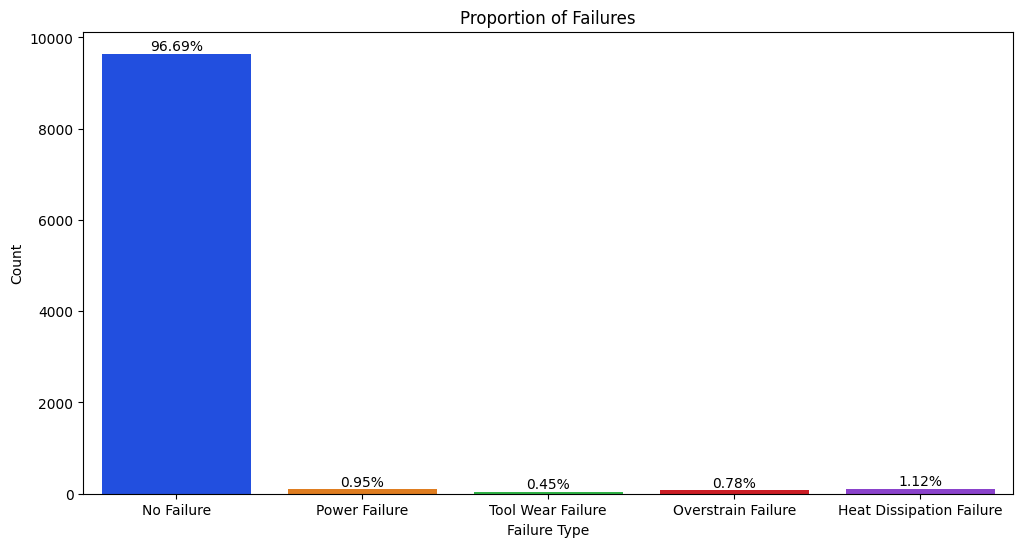

In [44]:
failure_count = df['Failure_type'].value_counts()

plt.figure(figsize =(12,6))
ax = sns.countplot(data = df, x = 'Failure_type', palette = 'bright')
plt.title('Proportion of Failures')
plt.xlabel('Failure Type')
plt.ylabel('Count')

total = len(df)
for p in ax.patches:
  height = p.get_height()
  percentage = (height/total) * 100
  ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
              ha = 'center', va = 'bottom')
plt.show()

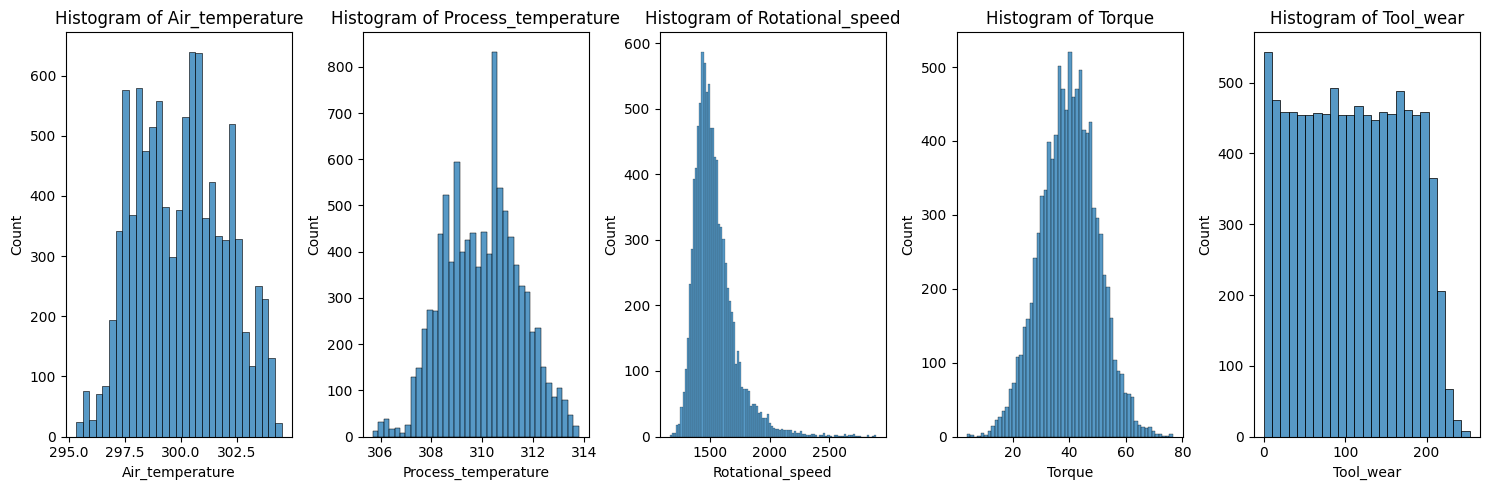

In [45]:
numeric_features = df.select_dtypes(include = ['int','float']).columns
categoric_features = ['Type']

fig, axes = plt.subplots(nrows = 1, ncols = len(numeric_features), figsize = (15,5))

for i, feature in enumerate(numeric_features):
  sns.histplot(data = df, x = feature, ax = axes[i])
  axes[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

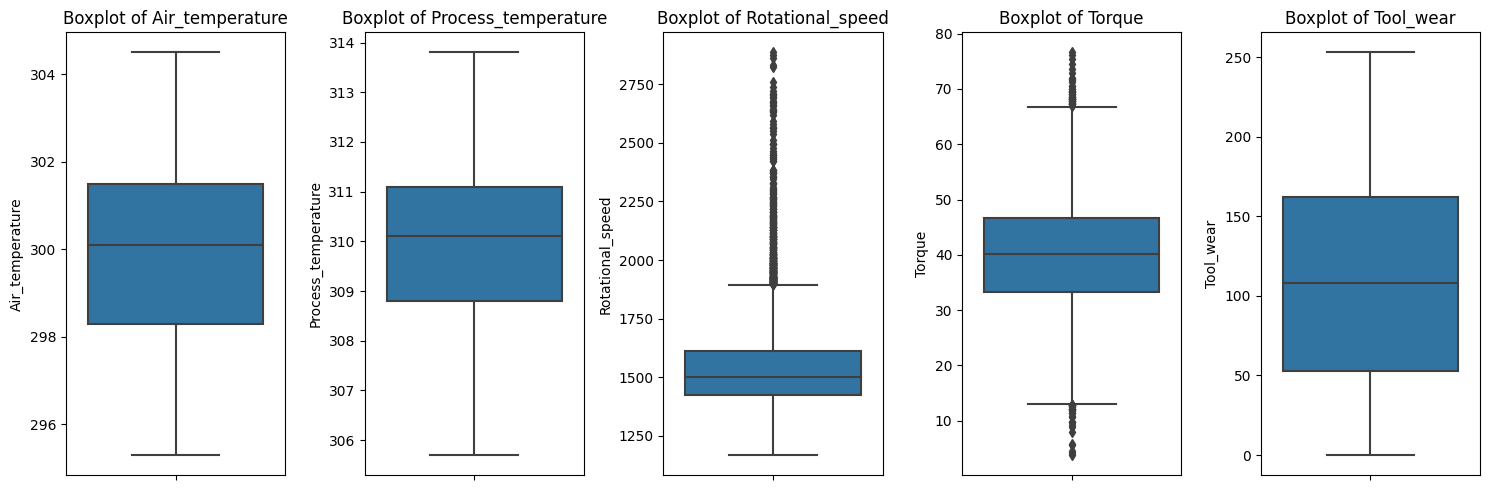

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = len(numeric_features), figsize = (15,5))

for i, feature in enumerate(numeric_features):
  sns.boxplot(data = df, y = feature, ax = axes[i])
  axes[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

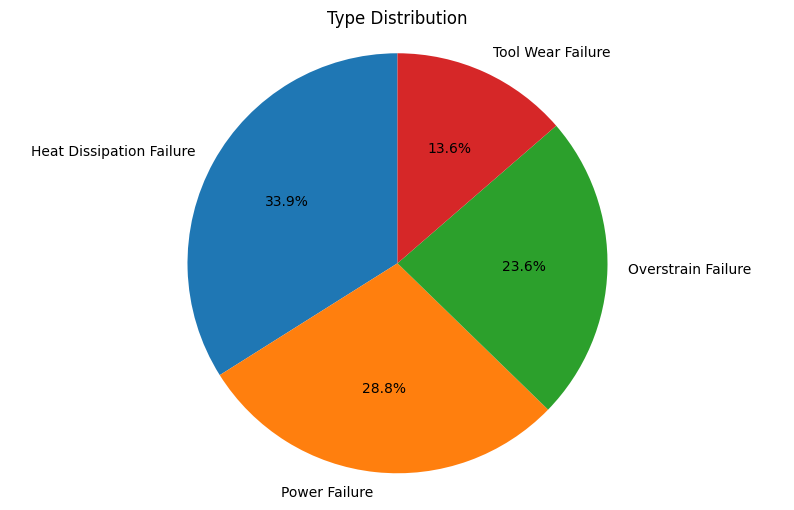

In [47]:
df_failure_type = df.loc[df['Failure_type'] != 'No Failure']

proportions = df_failure_type['Failure_type'].value_counts()

plt.figure(figsize = (10,6))
plt.pie(proportions, labels = proportions.index, autopct = '%1.1f%%', startangle= 90)
plt.axis('equal')
plt.title('Type Distribution')
plt.show()

<Axes: >

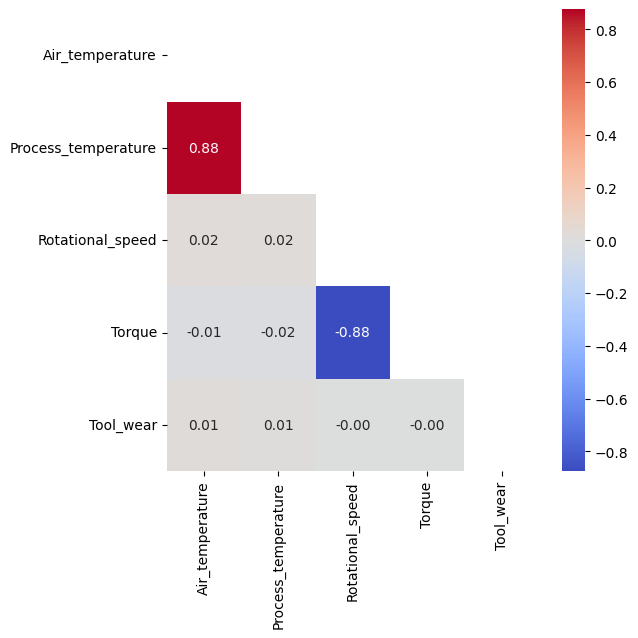

In [48]:
correlation = df.corr(numeric_only = True)
plt.figure(figsize = (6,6))
mask = np.triu(np.ones_like(correlation, dtype = bool))
sns.heatmap(correlation, annot = True, mask=mask, cmap ='coolwarm', fmt = '.2f')

In [49]:
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers = [
    ('num_trans', num_pipeline, numeric_features),
    ('cat_trans', cat_pipeline, categoric_features)
])

df_transformed = preprocessor.fit_transform(df)

encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(categoric_features)
new_column_names = list(numeric_features) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns = new_column_names)
df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951,-0.946,0.067,0.283,-1.696,0.000,0.000,1.000
1,-0.901,-0.879,-0.730,0.634,-1.649,0.000,1.000,0.000
2,-0.951,-1.014,-0.228,0.945,-1.617,0.000,1.000,0.000
3,-0.901,-0.946,-0.590,-0.048,-1.586,0.000,1.000,0.000
4,-0.901,-0.879,-0.730,0.002,-1.554,0.000,1.000,0.000


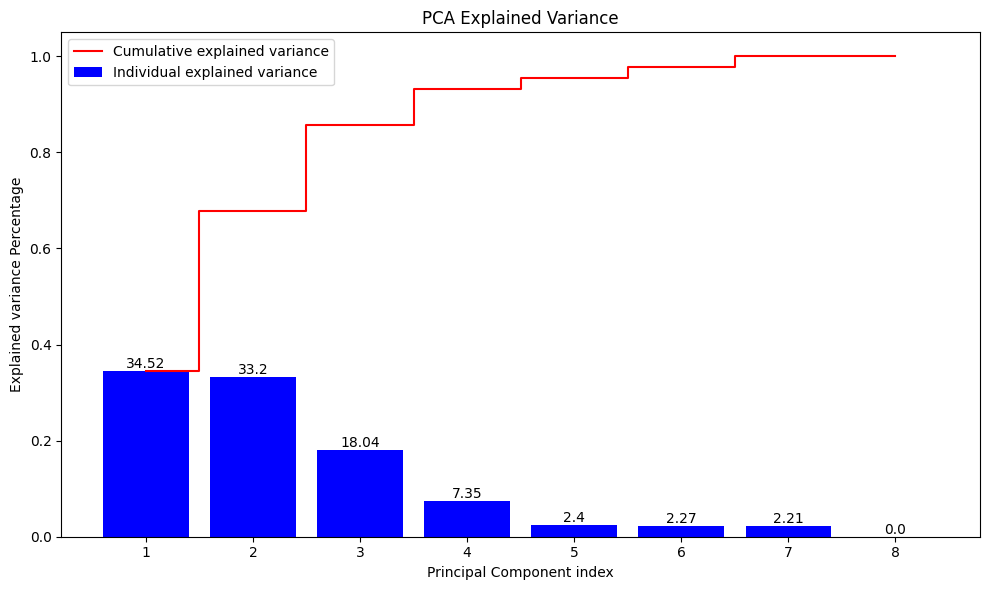

In [50]:
pca = PCA()
pca.fit(df_transformed)

exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

n_pca_components = len(exp_var)

plt.figure(figsize = (10,6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align = 'center',
               label = 'Individual explained variance', color = 'blue')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where = 'mid',
         label = 'Cumulative explained variance', color = 'red')

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval * 100, 2),
           va = 'bottom', ha = 'center', fontsize = 10)
plt.ylabel('Explained variance Percentage')
plt.xlabel('Principal Component index')
plt.xticks(ticks = list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

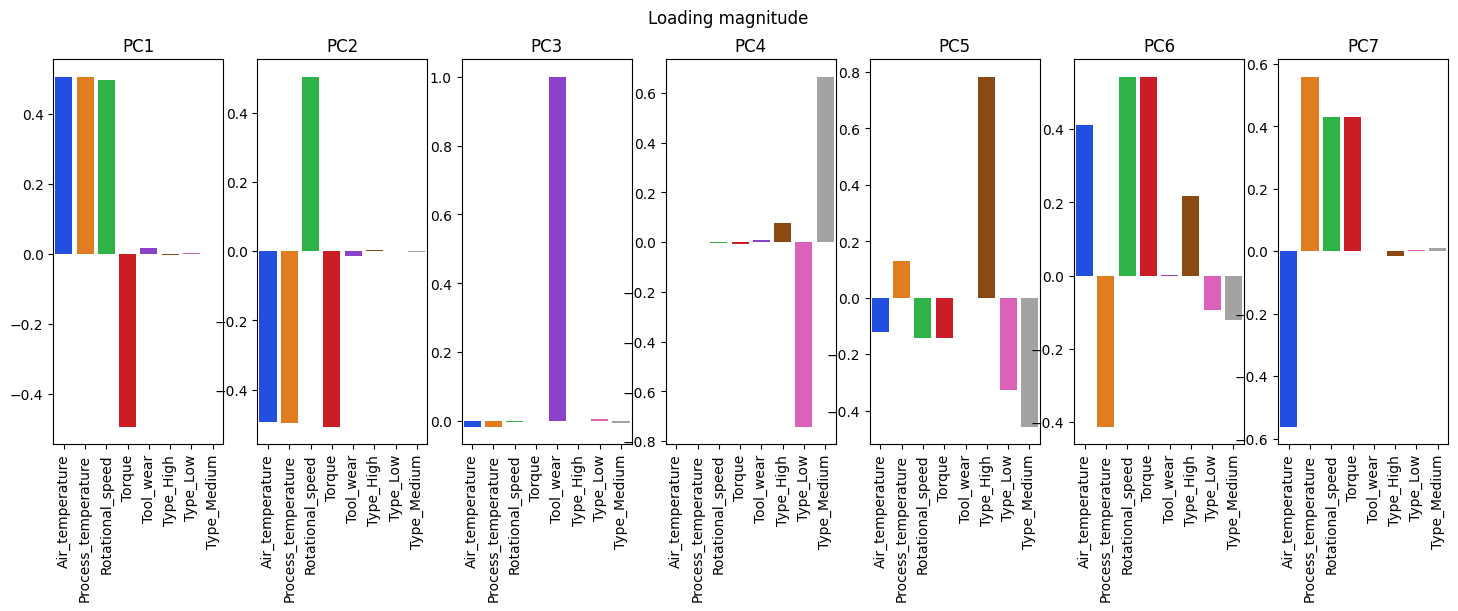

In [51]:
pca_7 = PCA(n_components = 7)
X_pca_7 = pd.DataFrame(data = pca_7.fit_transform(df_transformed), columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])

fig, axs = plt.subplots(ncols = 7, figsize = (18,5))
fig.suptitle('Loading magnitude')

pca_loading = pd.DataFrame(data = pca_7.components_, columns = new_column_names)

for i in range(7):
  ax = axs[i]
  sns.barplot(ax = ax, x = pca_loading.columns, y = pca_loading.values[i], palette = 'bright')
  ax.tick_params(axis = 'x', rotation = 90)
  ax.title.set_text(f'PC{str(i+1)}')
plt.show()

In [52]:
def get_metrics(y_true,y_pred):
  f1_score_per_class = f1_score(y_true,y_pred, average = None)

  dict_metrics = {
      'Accuracy': accuracy_score(y_true, y_pred),
      'Balanced Accuracy' : balanced_accuracy_score(y_true, y_pred),
      'Macro Recall' : recall_score(y_true, y_pred, average = 'macro'),
      'Macro Precision' : precision_score(y_true, y_pred, average = 'macro'),
      'Macro f1' : f1_score(y_true, y_pred, average = 'macro'),
      'F1 score per class' : f1_score_per_class
  }
  return dict_metrics


In [53]:
df_model = df.copy()
numerical_features = [*numeric_features]
X = df_model[numerical_features + categoric_features]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 0.2, stratify = y)

In [54]:
pipe_model_pca = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('pca',PCA(n_components=4)),
    ('model',RandomForestClassifier(random_state = 42))
    ])

weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train)
pipe_model_pca.fit(X_train,y_train, model__sample_weight = weights)

y_pred = pipe_model_pca.predict(X_test)

metrics = get_metrics(y_test, y_pred)

metrics

{'Accuracy': 0.9709273182957393,
 'Balanced Accuracy': 0.30503986000630023,
 'Macro Recall': 0.30503986000630023,
 'Macro Precision': 0.7275902602854744,
 'Macro f1': 0.359882129822811,
 'F1 score per class': array([0.08695652, 0.9851814 , 0.54545455, 0.18181818, 0.        ])}

In [55]:
pipe_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state = 42))
])

weights = class_weight.compute_sample_weight(class_weight = 'balanced',y = y_train)
pipe_model_no_pca.fit(X_train,y_train, model__sample_weight = weights)

y_pred = pipe_model_no_pca.predict(X_test)
metrics = get_metrics(y_test,y_pred)

metrics

{'Accuracy': 0.9543859649122807,
 'Balanced Accuracy': 0.8088413913217465,
 'Macro Recall': 0.8088413913217465,
 'Macro Precision': 0.5805520745597669,
 'Macro f1': 0.6480662154359346,
 'F1 score per class': array([0.78571429, 0.9762533 , 0.53658537, 0.7804878 , 0.16129032])}

In [56]:
cats_indices = [i for i, feature in enumerate(numerical_features + categoric_features) if feature in categoric_features]

pipe_model_smotenc = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smotenc', SMOTENC(categorical_features=cats_indices, random_state = 42)),
    ('model', GradientBoostingClassifier(random_state = 42))
])

pipe_model_smotenc.fit(X_train, y_train)

y_pred = pipe_model_smotenc.predict(X_test)

metrics = get_metrics(y_test, y_pred)

metrics

{'Accuracy': 0.9478696741854636,
 'Balanced Accuracy': 0.8551051358307641,
 'Macro Recall': 0.8551051358307641,
 'Macro Precision': 0.580598694230544,
 'Macro f1': 0.6617230015122039,
 'F1 score per class': array([0.8       , 0.97241379, 0.68292683, 0.72340426, 0.12987013])}

In [57]:
pipe_model_no_pca = Pipeline(steps=[
    ('preprocessor' , preprocessor),
    ('model',GradientBoostingClassifier(random_state = 42))
])

weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train)
pipe_model_no_pca.fit(X_train,y_train, model__sample_weight = weights)

params = {
    'model' : [
        LogisticRegressionCV(max_iter = 500, random_state = 42),
        RandomForestClassifier(random_state = 42),
        GradientBoostingClassifier(random_state =42),
        DummyClassifier()
    ],
}

grid = GridSearchCV(pipe_model_no_pca,params, cv = 3, scoring = 'f1_macro', n_jobs = -1, verbose = 1)
grid.fit(X_train, y_train)

results = pd.DataFrame(grid.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']

print('Best Model: ')
print(best_model_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Model: 
{'model': GradientBoostingClassifier(random_state=42)}


In [58]:
fine_tune_params = {
    'model__n_estimators' : [50, 100, 200, 300, 400, 500],
    'model__max_depth' : [None,5, 10, 15,20]
}

fine_tune_grid = GridSearchCV(pipe_model_no_pca, fine_tune_params, cv = 3, scoring = 'f1_macro', n_jobs = -1, verbose = 1)
fine_tune_grid.fit(X_train,y_train)

fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index,'params']

print('Best fine-tuned model: ')
print(fine_tuned_best_params)

tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best fine-tuned model: 
{'model__max_depth': 5, 'model__n_estimators': 100}


{'Accuracy': 0.981453634085213,
 'Balanced Accuracy': 0.619389803329191,
 'Macro Recall': 0.619389803329191,
 'Macro Precision': 0.652765143151542,
 'Macro f1': 0.6332290489502171,
 'F1 score per class': array([0.86956522, 0.99069767, 0.6       , 0.70588235, 0.        ])}

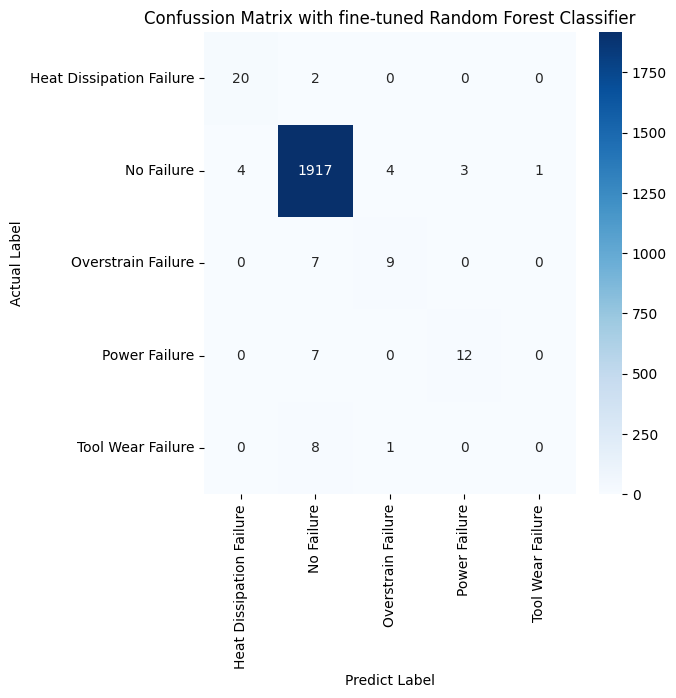

In [59]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap ='Blues',
            xticklabels = np.unique(y_test),
            yticklabels = np.unique(y_pred))
plt.xlabel('Predict Label')
plt.ylabel('Actual Label')
plt.title('Confussion Matrix with fine-tuned Random Forest Classifier')
plt.show()

In [60]:
with open('model.pkl','wb') as model_file:
    pickle.dump(tuned_model, model_file)